# Predicting reactions

## Intro
Predicting reactions based on reaction templates is important for synthetic biology, biotechnology, and other areas that need to establish connections between molecules that are not currently annotated in existing databases.
Examples of existing tools for application of reaction templates are:
* [BNICE](https://doi.org/10.1093/bioinformatics/bti213)
* [Pickaxe](https://github.com/tyo-nu/MINE-Database)

The basic mechanism of action is as follows:
1. Take template (e.g. R-C=O -> R-C-OH)
2. Take compound (e.g. C-C-C-C=O)
3. Apply template to compound and get the reaction (e.g. C-C-C-C=O -> C-C-C-C-OH)

A common way to represent reaction templates is [reaction SMARTS](https://www.daylight.com/dayhtml/doc/theory/theory.smarts.html). SMARTS serve as a substructure search linear molecule expression (analagous to regular expressions in text).

One of the existing python libraries for application of reaction SMARTS to compounds for reaction generation is [rdkit](https://www.rdkit.org/docs/source/rdkit.Chem.rdChemReactions.html).

## Predicting reactions using Rhea templates

This notebook generates SMARTS from generic Rhea reactions (reactions with R-compounds or star(\*)-compounds) and applies them as reactions.

1. Use RheaDB class to access the RheaDB data 

In [1]:
from pyrheadb.RheaDB import RheaDB
rdb = RheaDB()

Your Rhea DB version is 135
Using previously downloaded Rhea version


In [2]:
print('Reactions with * :',  len(rdb.df_reactions[rdb.df_reactions['class_reaction_flag']==True]))
print('Reactions with compounds defined :',  len(rdb.df_reactions[rdb.df_reactions['class_reaction_flag']==False]))

Reactions with * : 2394
Reactions with compounds defined : 14568


2. Use ReactionSmartsConverter class to identify Rhea reactions that can act as templates (class reactions) and convert them to SMARTS using atom mapping with [RXNMapper](https://github.com/rxn4chemistry/rxnmapper)

In [3]:
from pyrheadb.ReactionSmartsConverter import ReactionSmartsConverter
rxn_smarts_cvrt = ReactionSmartsConverter(rdb)

In [4]:
rxn_smarts_cvrt.convert_all_rhea_smiles_to_smarts()

Converting reaction SMILES into SMARTS


100%|███████████████████████████████████████| 1849/1849 [01:05<00:00, 28.12it/s]

{'6'}
{'1'}
{'1'}
{'1'}
{'1'}
{'1'}
{'1'}
{'56'}


3. Use ReactionPrediction class to apply the resulting reaction SMARTS to desired compounds

In [5]:
from pyrheadb.ReactionPrediction import ReactionPrediction

In [6]:
# Initiate ReactionPrediction class - do not forget to initiate it with RheaDB to be able to access Rhea data from the class
rxnpred = ReactionPrediction(rdb)

There are two possibilities to interpret reaction SMARTS:
1. All compounds are included into SMARTS. SMARTS will try to find a pattern match in provided compounds for every necessary reactant, including fully defined cofactors/cosubstrates (e.g. NADH, ATP, etc.)
2. Only use star (*/R) compounds in SMARTS. The default compounds will be added after product structure calculation for balance

* set_star_smarts_only: False - option 1 (reaction SMARTS applied as a whole)
* set_star_smarts_only: True - option 2 (only the star-compounds used)

**First, do the analysis with the full SMARTS**

In [7]:
rxnpred.set_star_smarts_only(False)

Now lets load SMARTS data that was generated with ReactionSmartsConverter

In [8]:
rxnpred.load_smarts_data()

In [9]:
print('Total SMARTS:', len(rxnpred.smarts_data))

Total SMARTS: 1653


In [10]:
rxnpred.smarts_data.keys()

dict_keys(['10092', '10100', '10144', '10216', '10272', '10324', '10328', '10332', '10344', '10352', '10396', '10448', '10520', '10592', '10604', '10652', '10736', '10740', '10832', '10856', '10868', '10872', '10900', '10968', '11000', '11036', '11044', '11048', '11136', '11164', '11192', '11216', '11272', '11316', '11332', '11344', '11388', '11472', '11484', '11488', '11540', '11552', '11580', '11628', '11640', '11644', '11660', '11664', '11716', '11804', '11888', '11924', '11988', '12008', '12020', '12032', '12072', '12076', '12088', '12136', '12140', '12164', '12280', '12288', '12316', '12364', '12484', '12588', '12593', '12657', '12665', '12673', '12709', '12713', '12745', '12833', '12937', '12957', '12969', '13013', '13057', '13093', '13189', '13205', '13269', '13273', '13301', '13329', '13381', '13421', '13425', '13569', '13577', '13609', '13733', '13737', '13749', '13781', '13805', '13877', '13881', '13905', '14233', '14257', '14269', '14289', '14297', '14333', '14349', '14389',

In [11]:
# Uncommit if you want to see all the smarts_data
#rxnpred.smarts_data

In [12]:
print('Example SMARTS:', rxnpred.smarts_data['39023'])

Example SMARTS: [O:33]=[C:34]([O-:35])[*:36][CH3:37].[CH3:1][c:2]1[cH:3][c:4]2[c:28]([cH:29][c:30]1[CH3:31])[N:14]([CH2:15][C@H:16]([OH:17])[C@H:18]([OH:19])[C@H:20]([OH:21])[CH2:22][O:23][P:24](=[O:25])([O-:26])[O-:27])[c:13]1[c:6]([c:7](=[O:8])[nH:9][c:10](=[O:11])[nH:12]1)[NH:5]2.[O:32]=[O:38]>>[CH3:1][c:2]1[cH:3][c:4]2[n:5][c:6]3[c:7](=[O:8])[n-:9][c:10](=[O:11])[n:12][c:13]-3[n:14]([CH2:15][C@H:16]([OH:17])[C@H:18]([OH:19])[C@H:20]([OH:21])[CH2:22][O:23][P:24](=[O:25])([O-:26])[O-:27])[c:28]2[cH:29][c:30]1[CH3:31].[OH2:32].[O:33]=[C:34]([O-:35])[*:36][CH2:37][OH:38]


**4. Predict products and reactions**

You can supply predict_products with:
* SMILES string of one compound. Example: "CCC(=O)[O-]"
* list of SMILES of compounds that are substrates of a single reaction and are reacting with each other. Example: \["CC=O", "NH3"]

From the practical point of view, enumerating several substrates for one reaction is required to generate permutations. This operation increases computational time to evaluate all options.
From the theoretical point of view, it is unlikely that more than two random molecules meet and react.
It was nicely put in words on [Reddit](https://www.reddit.com/r/chemistry/comments/18smdjd/are_there_any_chemical_reactions_that_actually/?rdt=50008): "It’s unlikely for 3 things to bounce into each other at the exact same time in the correct orientation. There are a lot of multi-component reactions but it usually happens in stages."

More on Molecularity: [Wikipedia](https://en.m.wikipedia.org/wiki/Molecularity)

Here we demonstrate how to test all Rhea reaction templates on one molecule and evaluate which products and which reactions we can get.

**Predict products**

In [13]:
rheaid2products=rxnpred.predict_products('CCC(=O)[O-]')

In [14]:
product_sets = [i for i in rheaid2products if i[1]]
print('Number of possible product sets that were obtained:',len(product_sets))

Number of possible product sets that were obtained: 3


In [15]:
product_sets

[('18969', [['[CH]C', 'O=C=O']]),
 ('38879', [['CCC(=O)[O-]']]),
 ('39283', [['CCC(=O)[O-]']])]

**Predict reactions**

In [16]:
df_pred_rxns=rxnpred.predict_reactions('CCC(=O)[O-]')

QC: number of unbalanced reactions generated: 0


In [17]:
df_pred_rxns

,rheaid,rxnsmiles,balance
0,18969,CCC(=O)[O-]>>[CH]C.O=C=O,True
1,38879,CCC(=O)[O-]>>CCC(=O)[O-],True
2,39283,CCC(=O)[O-]>>CCC(=O)[O-],True


Check smarts for one of the Rhea reactions (18969) which resulted in products for the selected compound

In [18]:
rxnpred.smarts_data['18969']

'[O:1]=[C:2]([O-:3])[*:4]>>[O:1]=[C:2]=[O:3].[*H:4]'

**Now, repeat with the star-only SMARTS (default option)**

In [19]:
rxnpred_only_star = ReactionPrediction(rdb)
rxnpred_only_star.load_smarts_data()
print('Total SMARTS:', len(rxnpred_only_star.smarts_data))

Total SMARTS: 1653


In [20]:
rheaid_star_only2products=rxnpred_only_star.predict_products('CCC(=O)[O-]')

In [21]:
product_sets = [i for i in rheaid_star_only2products if i[1]]
print('Number of possible product sets that were obtained:', len(product_sets))

Number of possible product sets that were obtained: 36


In [22]:
df_pred_rxns_only_star=rxnpred_only_star.predict_reactions('CCC(=O)[O-]')

QC: number of unbalanced reactions generated: 0


In [23]:
df_pred_rxns_only_star

,rheaid,rxnsmiles,balance
0,10968,CCC(=O)[O-].[CH3]C([CH3])([CH2]OP(=O)([O-])OP(...,True
1,15421,CCC(=O)[O-].[CH3]C([CH3])([CH2]OP(=O)([O-])OP(...,True
2,18969,CCC(=O)[O-]>>[CH]C.O=C=O,True
3,23012,CCC(=O)[O-].[CH3][S+]([CH2][CH2][C@H]([NH3+])C...,True
4,24336,CCC(=O)[O-].[CH3]C([CH3])([CH2]OP(=O)([O-])OP(...,True
5,30299,CCC(=O)[O-].O=C([O-])[CH2][CH2]C(=O)C(=O)[O-]....,True
6,32655,CCC(=O)[O-].C=[CH][CH2]c1[cH][cH]c([OH])c(O[CH...,True
7,38855,CCC(=O)[O-].O=O.[Fe+2].[Fe+2]>>CC(O)C(=O)[O-]....,True
8,38879,CCC(=O)[O-]>>CCC(=O)[O-],True
9,38883,CCC(=O)[O-].[CH3]C([CH3])([CH2]OP(=O)([O-])OP(...,True


As you can see, there are more reactions generated with ReactionPrediction.set_star_smarts_only(True). This is because we did not have to add cofactors into the "mix" and all the defined cofactors were automatically found and applied to generate valid balanced reactions!

Therefore, _star_smarts_only = True_ is the default option. However, we kept the ability to use full SMARTS by resetting this option to False as was shown in the beginning.

**Group reactions based on International chemical identifier for reactions (RInChI).**

[Link to article on RInChI](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-018-0277-8)

In [24]:
df_grouped_by_rinchikey = rxnpred_only_star.group_predicted_reactions_based_on_rinchikey(df_pred_rxns_only_star)

Calculating Reaction InChiKeys


In [25]:
df_grouped_by_rinchikey

,Web-RInChIKey,rheaid,rxnsmiles
0,Web-RInChIKey=AMJUVJCMURZMESFZW-LUHFFFADPSCTJSA,74371,CCC(=O)[O-].O=C([O-])c1[cH][cH][cH]n[cH]1>>CCC...
1,Web-RInChIKey=CPJBTPNPEMNQHDDBC-DPCSRZTMQPBCTSA,"44544, 67080, 67684, 78843",CCC(=O)[O-].[NH2]c1n[cH]nc2c1n[cH]n2[C@@H]1O[C...
2,Web-RInChIKey=GXCNOXHEWCQIOIVZZ-FQVYYODZYXBIPSA,32655,CCC(=O)[O-].C=[CH][CH2]c1[cH][cH]c([OH])c(O[CH...
3,Web-RInChIKey=LEZUKENBQKXJNKNFN-LUHFFFADPSCTJSA,63508,CCC(=O)[O-].O=O>>CC(OO)C(=O)[O-]
4,Web-RInChIKey=LNTVQHFTQCBDCLZMI-LUHFFFADPSCTJSA,"38855, 39983",CCC(=O)[O-].O=O.[Fe+2].[Fe+2]>>CC(O)C(=O)[O-]....
5,Web-RInChIKey=MPSRMLHNVBSKOXPYB-ALDGHLASYPSDQSA,51580,CCC(=O)[O-].[CH3]C([CH3])([CH2]OP(=O)([O-])OP(...
6,Web-RInChIKey=MUKGCYMTMLIGNJXYJ-HUHFFFADPSCTJSA,40727,CCC(=O)[O-].[CH3][CH2][CH2][CH2][CH2][CH2][CH2...
7,Web-RInChIKey=OMDJOPNNLQOINANGJ-ARARVLTYBCREUSA,"15421, 24336, 38883, 48340, 52860, 54536",CCC(=O)[O-].[CH3]C([CH3])([CH2]OP(=O)([O-])OP(...
8,Web-RInChIKey=ONGNEYSFPJQDHYMUC-HUHFFFADPSCTJSA,30299,CCC(=O)[O-].O=C([O-])[CH2][CH2]C(=O)C(=O)[O-]....
9,Web-RInChIKey=PEENSMBOTUETFZVYE-LUHFFFADPSCTJSA,73487,CCC(=O)[O-].O=C([O-])c1[cH]c(=O)[nH]c(=O)[nH]1...


The number of unique reactions descreased and Rhea reaction identifiers are grouped for the same Web-RInChIKey.

# Analysis of the reaction templates

Above we showed application of the library to predict reactions and products for a single compound. Using pyrheadb.ReactionPrediction it is possible to make several compounds fitting a reaction template to react.

Here we are showing the distribution of the number of templates per Rhea reaction (of ~ 3 thousand reactions with at least one R/star-compound).

The number of templates should be x2 of the number of Rhea reactions with R group, since they need to be tried as forward and reverse.

In [26]:
def count_substrate_templates(rxnpredobj):
    counts_reactants = []
    counts_products = []
    counts_together = []
    for rheaid, rxn in rxnpredobj.rdkit_stereo_rxn_data.items():
        num_reactants = rxn.GetNumReactantTemplates()
        num_products = rxn.GetNumProductTemplates()
        if num_reactants>=3 or num_products>=3:
            print('3+ substrate templates in', rheaid)
        counts_products.append(num_products)
        counts_reactants.append(num_reactants)
        counts_together.extend([num_reactants, num_products])
    return counts_reactants, counts_products, counts_together

In [27]:
import matplotlib.pyplot as plt
from collections import Counter

# Data
def plot_bar(elements):

    # Count the occurrences of each category
    counter = Counter(elements)

    # Ensure all categories are present
    categories = ['1', '2', '3+']
    counts = [counter[1], counter[2], sum(v for k, v in counter.items() if k >= 3)]

    # Plot
    plt.figure(figsize=(10, 6))
    bars = plt.bar(categories, counts, color='skyblue')

    # Add counts on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')

    plt.xlabel('Number of substrate templates')
    plt.ylabel('Number of Rhea class reactions (R/star-reactions)')
    plt.title('Number of Reaction Templates Distribution by Number of Substrate Templates')
    plt.show()

**WITHOUT defined cofactors included into SMARTS**

In [28]:
counts_reactants_1, counts_products_1, counts_together_1 = count_substrate_templates(rxnpred_only_star)

3+ substrate templates in 65032


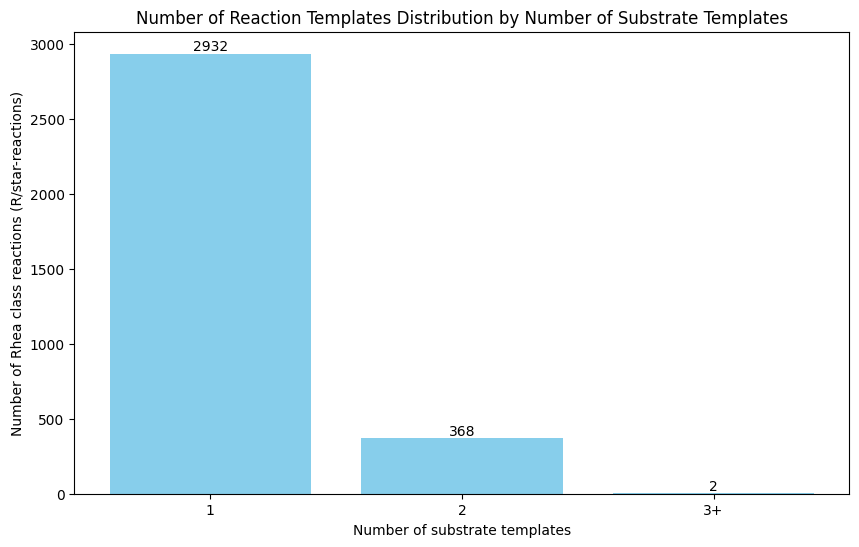

In [29]:
plot_bar(counts_together_1)

In [30]:
# Commit two other versions of the plot since they do not add much info
#plot_bar(counts_reactants_1)

In [31]:
#plot_bar(counts_products_1)

**WITH defined cofactors included into SMARTS**

In [32]:
counts_reactants_2, counts_products_2, counts_together_2 = count_substrate_templates(rxnpred)

3+ substrate templates in 10396
3+ substrate templates in 10448
3+ substrate templates in 10592
3+ substrate templates in 10652
3+ substrate templates in 10832
3+ substrate templates in 10968
3+ substrate templates in 11000
3+ substrate templates in 11036
3+ substrate templates in 11472
3+ substrate templates in 11484
3+ substrate templates in 11640
3+ substrate templates in 11644
3+ substrate templates in 11804
3+ substrate templates in 11888
3+ substrate templates in 13189
3+ substrate templates in 13421
3+ substrate templates in 13781
3+ substrate templates in 13881
3+ substrate templates in 14269
3+ substrate templates in 14289
3+ substrate templates in 14513
3+ substrate templates in 14673
3+ substrate templates in 15181
3+ substrate templates in 15205
3+ substrate templates in 15221
3+ substrate templates in 15421
3+ substrate templates in 15437
3+ substrate templates in 15629
3+ substrate templates in 15965
3+ substrate templates in 16073
3+ substrate templates in 16153
3+ subst

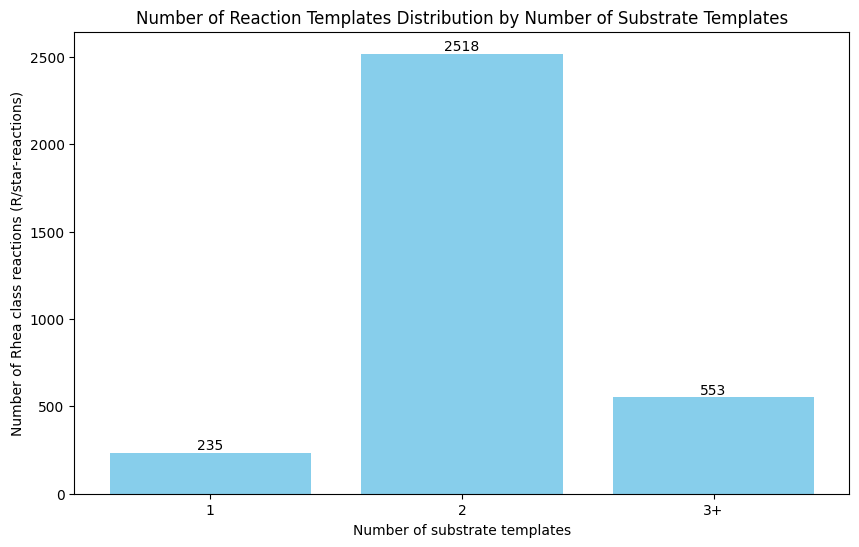

In [33]:
plot_bar(counts_together_2)

Comparing only-star templates with all-compound templates, we see, that treating defined cofactors separately brings advantage as it reduces the need for combinatorial increase in calculations due to the requirement to have permutations.

Most of the template reaction can be treated as singe substrate template (single SMILES string input to predict_reactions() and predict_products())